# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass


## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        raise NotImplementedError("Not implemented!")

    def forward(self, x):
        raise NotImplementedError("Not implemented!")
        # Uncomment the return once implemented
        # return output


def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [4]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [7]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

NotImplementedError: Not implemented!

# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

Training with 16 hidden neurons...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.350841
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.559689
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.138458
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.643810
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.531307
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.386598
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.350976
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.374969
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.768566
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.249671
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.343794
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.299898
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.380971
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.241029
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.299955
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.266572
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.396956
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.242751
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.669436
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.4

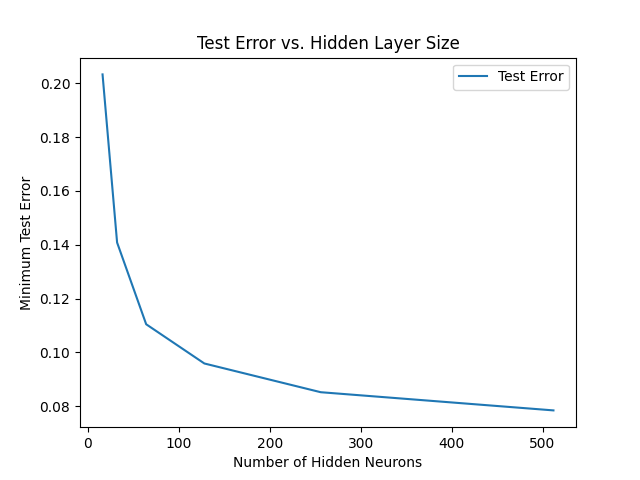

In [8]:
# Your code here
#Defining a network with a single hidden layer
class SimpleNet(nn.Module):
    def __init__(self, hidden_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)  # Fully connected layer from input to hidden layer
        self.fc2 = nn.Linear(hidden_size, 10)  # Output layer with 10 output classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        x = F.relu(self.fc1(x))  # Apply ReLU to the hidden layer
        x = F.log_softmax(self.fc2(x), dim=1)  # Log softmax for classification output
        return x

#Modify the trainer to store errors
import numpy as np

def run_training_epoch(training_params, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break
    return train_loss / len(train_loader.dataset)  # Return average training loss

# Modify predict to return test loss and accuracy
def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction="sum").item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * accuracy,
        )
    )
    return test_loss, accuracy  # Return test loss and accuracy

#Create a for loop to iterate over different hidden sizes
import matplotlib.pyplot as plt

def explore_width(hidden_sizes, training_params, device, train_loader, test_loader):
    train_errors = []
    test_errors = []

    for hidden_size in hidden_sizes:
        print(f"Training with {hidden_size} hidden neurons...")
        model = SimpleNet(hidden_size).to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

        min_test_error = float('inf')  # To track the minimum test error
        
        for epoch in range(1, training_params.epochs + 1):
            train_loss = run_training_epoch(training_params, model, device, train_loader, optimizer, epoch)
            test_loss, _ = predict(model, device, test_loader)
            
            # Add print statements here to check the loss at the end of each epoch
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}")
            print(f"Epoch {epoch}: Test Loss: {test_loss:.4f}")

            # Track minimum test error
            if test_loss < min_test_error:
                min_test_error = test_loss
            
            scheduler.step()

            if training_params.dry_run:
                break

        train_errors.append(train_loss)
        test_errors.append(min_test_error)  # Store the minimum test error

    # Plot the results
    plt.figure()
    plt.plot(hidden_sizes, test_errors, label="Test Error")
    plt.xlabel("Number of Hidden Neurons")
    plt.ylabel("Minimum Test Error")
    plt.title("Test Error vs. Hidden Layer Size")
    plt.legend()
    plt.show()

hidden_sizes = [16, 32, 64, 128, 256, 512]
training_params = TrainingParameters(epochs=2, dry_run=False)
device, train_kwargs, test_kwargs = configure_training_device(training_params)
transform = build_preprocessing_transform(training_params)
train_loader, test_loader = build_data_loaders(train_kwargs, test_kwargs, transform)

# Run the experiment
explore_width(hidden_sizes, training_params, device, train_loader, test_loader)


Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

Training with 1 hidden layers...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.347977
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.849847
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.573218
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.492310
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.363388
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.335886
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.189028
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.331830
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.569642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.212848
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.226957
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.370754
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.316798
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.154936
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.196455
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.115495
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.234689
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.149980
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.468361
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.233

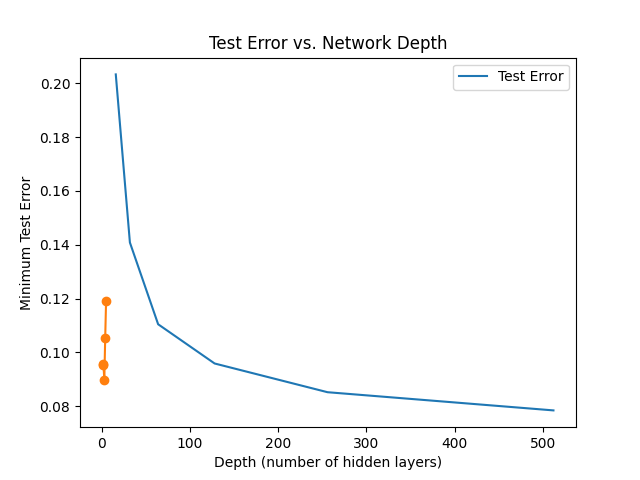

In [9]:
# Your code here
#Define a class for networks with varying depths
class DeepNet(nn.Module):
    def __init__(self, hidden_size, depth):
        super(DeepNet, self).__init__()
        layers = []
        input_size = 28 * 28  # MNIST input size
        output_size = 10  # MNIST has 10 output classes
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        
        # Hidden layers (vary depth)
        for _ in range(depth - 1):  # depth - 1 because we already added one layer
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return F.log_softmax(self.network(x), dim=1)

#Modify the training function to explore depths
def explore_depth(depths, hidden_size, training_params, device, train_loader, test_loader):
    train_errors = []
    test_errors = []

    for depth in depths:
        print(f"Training with {depth} hidden layers...")
        model = DeepNet(hidden_size, depth).to(device)
        optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
        scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

        min_test_error = float('inf')  # To track the minimum test error
        
        for epoch in range(1, training_params.epochs + 1):
            train_loss = run_training_epoch(training_params, model, device, train_loader, optimizer, epoch)
            test_loss, _ = predict(model, device, test_loader)

            # Add print statements here to check the loss at the end of each epoch
            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}")
            print(f"Epoch {epoch}: Test Loss: {test_loss:.4f}")
            
            # Track minimum test error
            if test_loss < min_test_error:
                min_test_error = test_loss
            
            scheduler.step()

            if training_params.dry_run:
                break

        train_errors.append(train_loss)
        test_errors.append(min_test_error)  # Store the minimum test error
    
    return train_errors, test_errors

# Plot the results
import matplotlib.pyplot as plt

# Define depths to test and hidden size
depths = [1, 2, 3, 4, 5]  # Vary depth
hidden_size = 128  # Use a fixed hidden size

# Run the exploration
train_errors, test_errors = explore_depth(depths, hidden_size, training_params, device, train_loader, test_loader)

# Plot the minimum test error with respect to depth
plt.plot(depths, test_errors, marker='o')
plt.xlabel('Depth (number of hidden layers)')
plt.ylabel('Minimum Test Error')
plt.title('Test Error vs. Network Depth')
plt.show()
